<a href="https://colab.research.google.com/gist/Ash-Twin/6cf539a66f123a7f3f658c722668ce85/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# !pip install umap-learn[plot]
# !pip install holoviews==1.12.7
# !pip install -U ipykernel

In [10]:
# Load the MNIST data
# upload the data first
import pandas as pd
mount_root = './'
train_in = pd.read_csv(mount_root+'train_in.csv', header=None)
train_out = pd.read_csv(mount_root+'train_out.csv', header=None)
test_in = pd.read_csv(mount_root+'test_in.csv', header=None)
test_out = pd.read_csv(mount_root+'test_out.csv', header=None)
X_train = train_in.to_numpy()
y_train = train_out.to_numpy().flatten()
X_test = test_in.to_numpy()
y_test = test_out.to_numpy().flatten()

In [11]:
import numpy as np
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

# Calculate the centers for each digit class
centers = []
for digit in range(10):
    digit_images = train_in[train_out[0] == digit]
    center = digit_images.mean(axis=0)
    centers.append(center)

# Calculate distances between centers
distances = np.zeros((10, 10))

for i in range(10):
    for j in range(i+1, 10):
        dist = distance.euclidean(centers[i], centers[j])
        distances[i, j] = dist
        distances[j, i] = dist

# Function to classify a new image based on the nearest center
def classify_image(image):
    min_distance = float('inf')
    predicted_digit = None
    for digit in range(10):
        dist = distance.euclidean(image, centers[digit])
        if dist < min_distance:
            min_distance = dist
            predicted_digit = digit
    return predicted_digit

# Classify test images and calculate accuracy
correct_predictions = 0
total_images = test_in.shape[0]
for i in range(total_images):
    test_image = test_in.iloc[i, :].values
    true_label = test_out.iloc[i, 0]
    predicted_label = classify_image(test_image)
    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_images
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 80.40%


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

# Combine input and output data
mnist_data = pd.concat([train_in, train_out], axis=1)

# Extract labels and features
labels = mnist_data.iloc[:, -1]
features = mnist_data.iloc[:, :-1]

# Perform PCA dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(features)

# Perform umap
ump = UMAP()
ump_result = ump.fit_transform(features)
# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap=plt.colormaps['viridis'])
plt.title('PCA')

plt.subplot(132)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=plt.colormaps['viridis'])
plt.title('t-SNE')

plt.subplot(133)
plt.scatter(ump_result[:, 0],ump_result[:, 1],c=labels,cmap=plt.colormaps['viridis'])
plt.title('UMAP')

plt.tight_layout()
plt.show()


ImportError: Numba needs NumPy 1.24 or less

In [31]:
from sklearn.metrics import accuracy_score

class NearestMeanClassifier:
    def __init__(self):
        self.class_means = None

    def fit(self, X, y):
        unique_classes = np.unique(y)
        self.class_means = {}

        for c in unique_classes:
            class_mean = np.mean(X[y == c], axis=0)
            self.class_means[c] = class_mean

    def predict(self, X):
        if self.class_means is None:
            raise ValueError("Classifier not trained. Please use the 'fit' method first.")

        predictions = []
        for sample in X:
            distances = {c: np.linalg.norm(sample - mean) for c, mean in self.class_means.items()}
            predicted_class = min(distances, key=distances.get)
            predictions.append(predicted_class)

        return np.array(predictions)

classifier = NearestMeanClassifier()
classifier.fit(X_train, y_train)

# Make predictions on the test set
nm_pred = classifier.predict(X_test)

# Calculate and print the accuracy
nm_accuracy = accuracy_score(y_test, nm_pred)
print(f"Accuracy of Nearest Mean Classifier: {nm_accuracy * 100:.2f}%")

Accuracy of Nearest Mean Classifier: 80.40%


In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(train_in,train_out.values.ravel())
knn_pred = knn_classifier.predict(test_in.values)
knn_accuracy = accuracy_score(test_out,knn_pred)

print(f"Accuracy of KNN Classifier: {knn_accuracy * 100:.2f}%")

Accuracy of KNN Classifier: 91.40%


<Axes: title={'center': 'kNN'}>

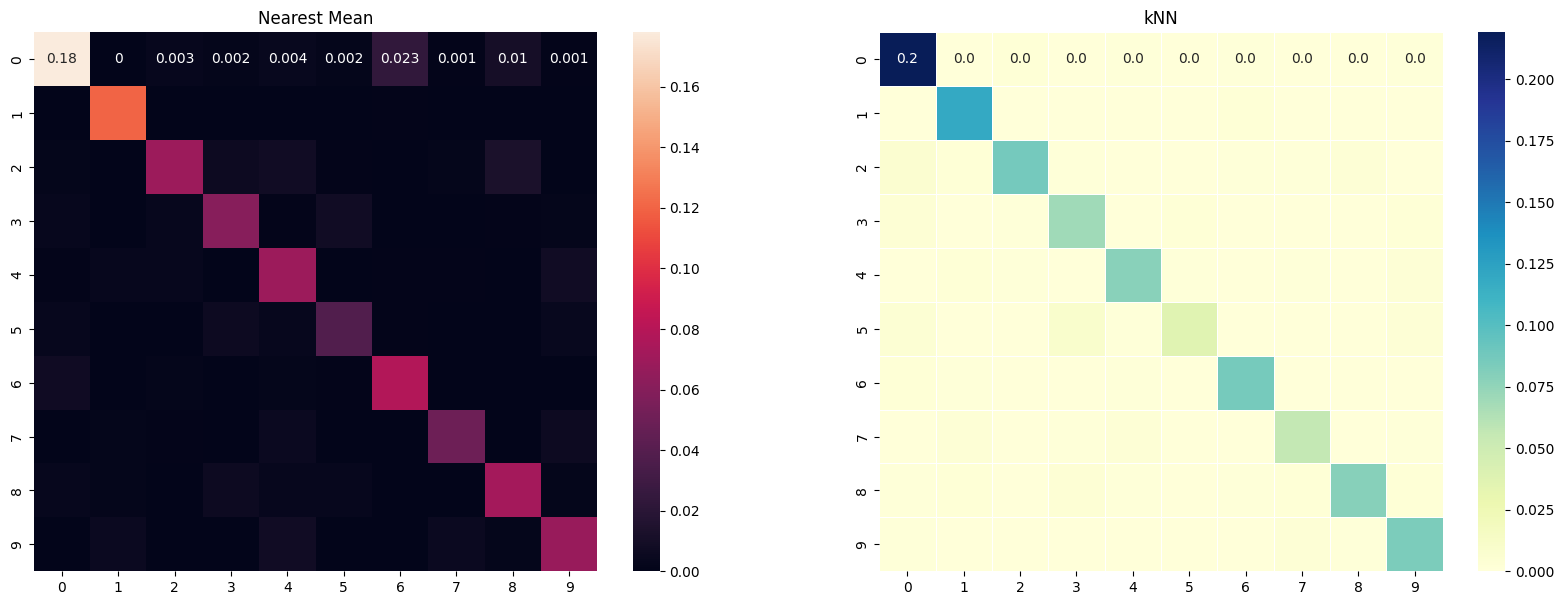

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.title("Nearest Mean")
nm_cfm = confusion_matrix(y_test,nm_pred)
sns.heatmap(nm_cfm/np.sum(nm_cfm),annot=True)

plt.subplot(122)
plt.title("kNN")
knn_cfm = confusion_matrix(y_test,knn_pred)
sns.heatmap(knn_cfm/np.sum(knn_cfm), annot=True, fmt=".1f", linewidth=.5, cmap="YlGnBu")



In [33]:
def unit_step_func(x):
  return np.where(x>0,1,0)

class Perceptron:
    def __init__(self, num_features, num_classes):
        # Initialize weights and bias
        self.weights = np.random.rand(num_features, num_classes)
        self.bias = np.random.rand(num_classes)

    def train(self, X_train, y_train, learning_rate, num_epochs):
        for epoch in range(num_epochs):
            for i in range(X_train.shape[0]):
                # Forward pass
                z = np.dot(X_train[i], self.weights) + self.bias
                y_pred = np.argmax(z)

                # Backpropagation
                if y_pred != y_train[i]:
                    self.weights[:, y_pred] -= learning_rate * X_train[i]
                    self.bias[y_pred] -= learning_rate
                    self.weights[:, y_train[i]] += learning_rate * X_train[i]
                    self.bias[y_train[i]] += learning_rate

    def predict(self, X_test):
        num_samples = X_test.shape[0]
        y_pred = np.zeros(num_samples, dtype=int)

        for i in range(num_samples):
            z = np.dot(X_test[i], self.weights) + self.bias
            y_pred[i] = np.argmax(z)

        return y_pred



In [34]:
num_features = X_train.shape[1]  # Number of features
num_classes = 10                # Number of classes
learning_rate = 0.01
num_epochs = 100

perceptron = Perceptron(num_features, num_classes)

# Train the perceptron on the training data
perceptron.train(X_train, y_train, learning_rate, num_epochs)

# Make predictions on the test data
p_pred = perceptron.predict(X_test)

# Evaluate accuracy using scikit-learn's accuracy_score
p_accuracy = accuracy_score(y_test, p_pred)
print(f"Accuracy of Perceptron on Test Data: {p_accuracy * 100:.2f}%")


Accuracy of Perceptron on Test Data: 84.90%
